# **Brain Tumour MRI Classification**

In [1]:
# General Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
from PIL import Image


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

SEED = 111
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

Using device: cuda


In [2]:
# Define paths
USER_PATH = "/kaggle/input/brain-tumor-mri-dataset"
TRAIN_DIR = os.path.join(USER_PATH, 'Training')
TEST_DIR = os.path.join(USER_PATH, 'Testing')

# Image dimensions and channels
image_dim = (168, 168)
n_channels = 1
batch_size = 32

# Define the image transformations
# Grayscale is used as the notebook specifies n_channels=1
image_transforms = transforms.Compose([
    transforms.Resize(image_dim),
    transforms.Grayscale(num_output_channels=n_channels),
    transforms.ToTensor(),
    # Normalizing for single channel
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create the full dataset using ImageFolder
full_train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=image_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=image_transforms)

# (Optional but recommended) Create a validation split from the training data
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# Class mappings
class_names = full_train_dataset.classes
class_mappings = full_train_dataset.class_to_idx
inv_class_mappings = {v: k for k, v in class_mappings.items()}
print("\nClass Mappings:", class_mappings)

Number of training samples: 5140
Number of validation samples: 572
Number of testing samples: 1311

Class Mappings: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


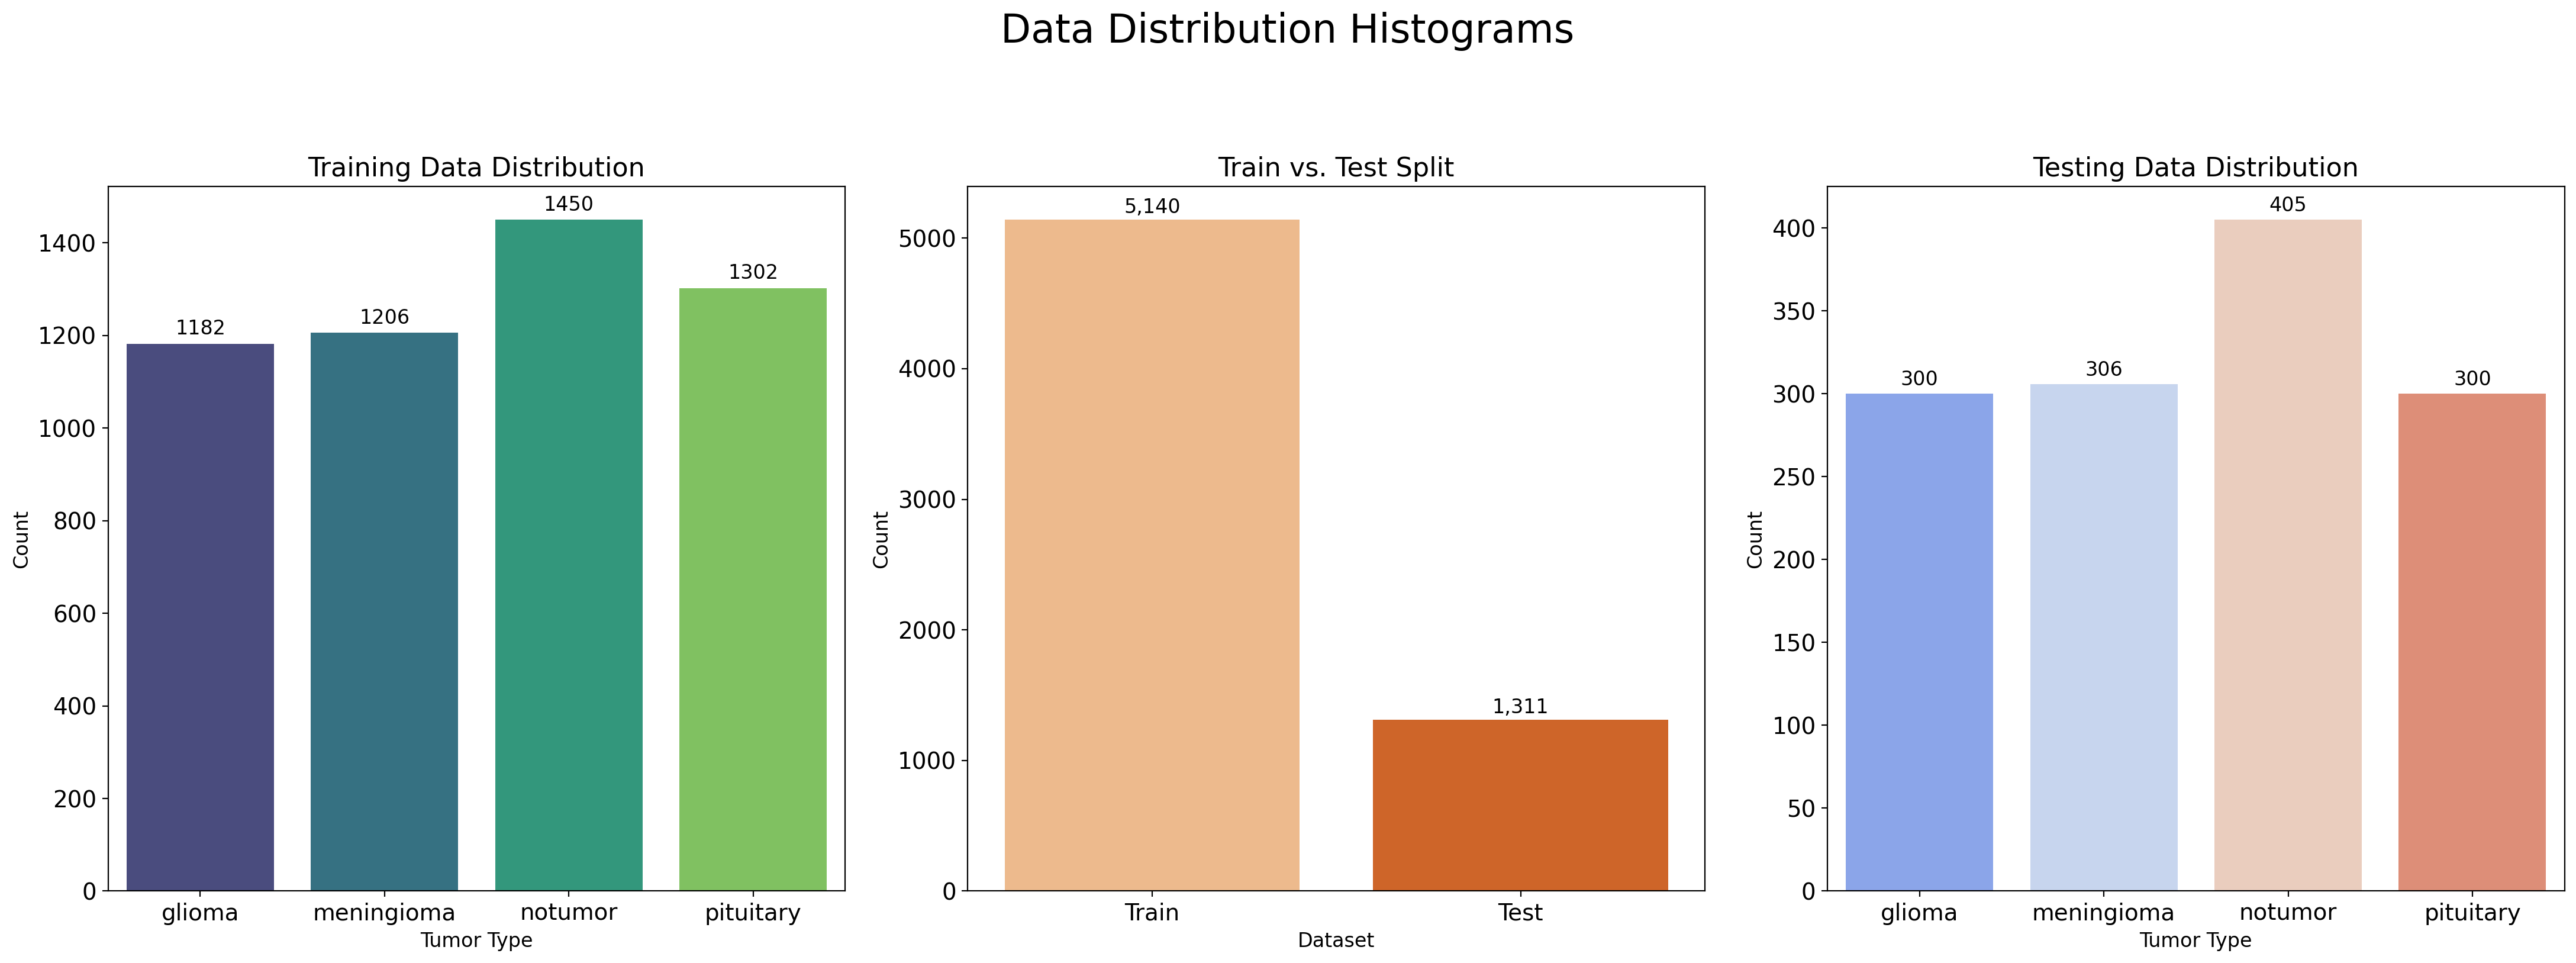

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure with three subplots
fig, ax = plt.subplots(ncols=3, figsize=(22, 8))
fig.suptitle('Data Distribution Histograms', fontsize=24, y=1.02)


# --- 1. Plotting training data distribution ---

# Get label indices from datasets
train_indices = [label for _, label in train_dataset]
class_counts_train = [train_indices.count(i) for i in range(len(class_names))]

# FIX: Convert lists to NumPy arrays
sns.barplot(x=np.array(class_names), y=np.array(class_counts_train), ax=ax[0], palette='viridis')
ax[0].set_title('Training Data Distribution', fontsize=16)
ax[0].set_xlabel('Tumor Type', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
# Add count labels on top of the bars
for i, count in enumerate(class_counts_train):
    ax[0].text(i, count + 20, str(count), ha='center', fontsize=12)


# --- 2. Plotting distribution of train/test split ---

split_labels = ['Train', 'Test']
split_counts = [len(train_dataset), len(test_dataset)]

# FIX: Convert lists to NumPy arrays
sns.barplot(x=np.array(split_labels), y=np.array(split_counts), ax=ax[1], palette='Oranges')
ax[1].set_title('Train vs. Test Split', fontsize=16)
ax[1].set_xlabel('Dataset', fontsize=12)
ax[1].set_ylabel('Count', fontsize=12)
# Add count labels on top of the bars
for i, count in enumerate(split_counts):
    ax[1].text(i, count + 50, f'{count:,}', ha='center', fontsize=12)


# --- 3. Plotting testing data distribution ---

# Get label indices from datasets
test_indices = [label for _, label in test_dataset]
class_counts_test = [test_indices.count(i) for i in range(len(class_names))]

# FIX: Convert lists to NumPy arrays
sns.barplot(x=np.array(class_names), y=np.array(class_counts_test), ax=ax[2], palette='coolwarm')
ax[2].set_title('Testing Data Distribution', fontsize=16)
ax[2].set_xlabel('Tumor Type', fontsize=12)
ax[2].set_ylabel('Count', fontsize=12)
# Add count labels on top of the bars
for i, count in enumerate(class_counts_test):
    ax[2].text(i, count + 5, str(count), ha='center', fontsize=12)


plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

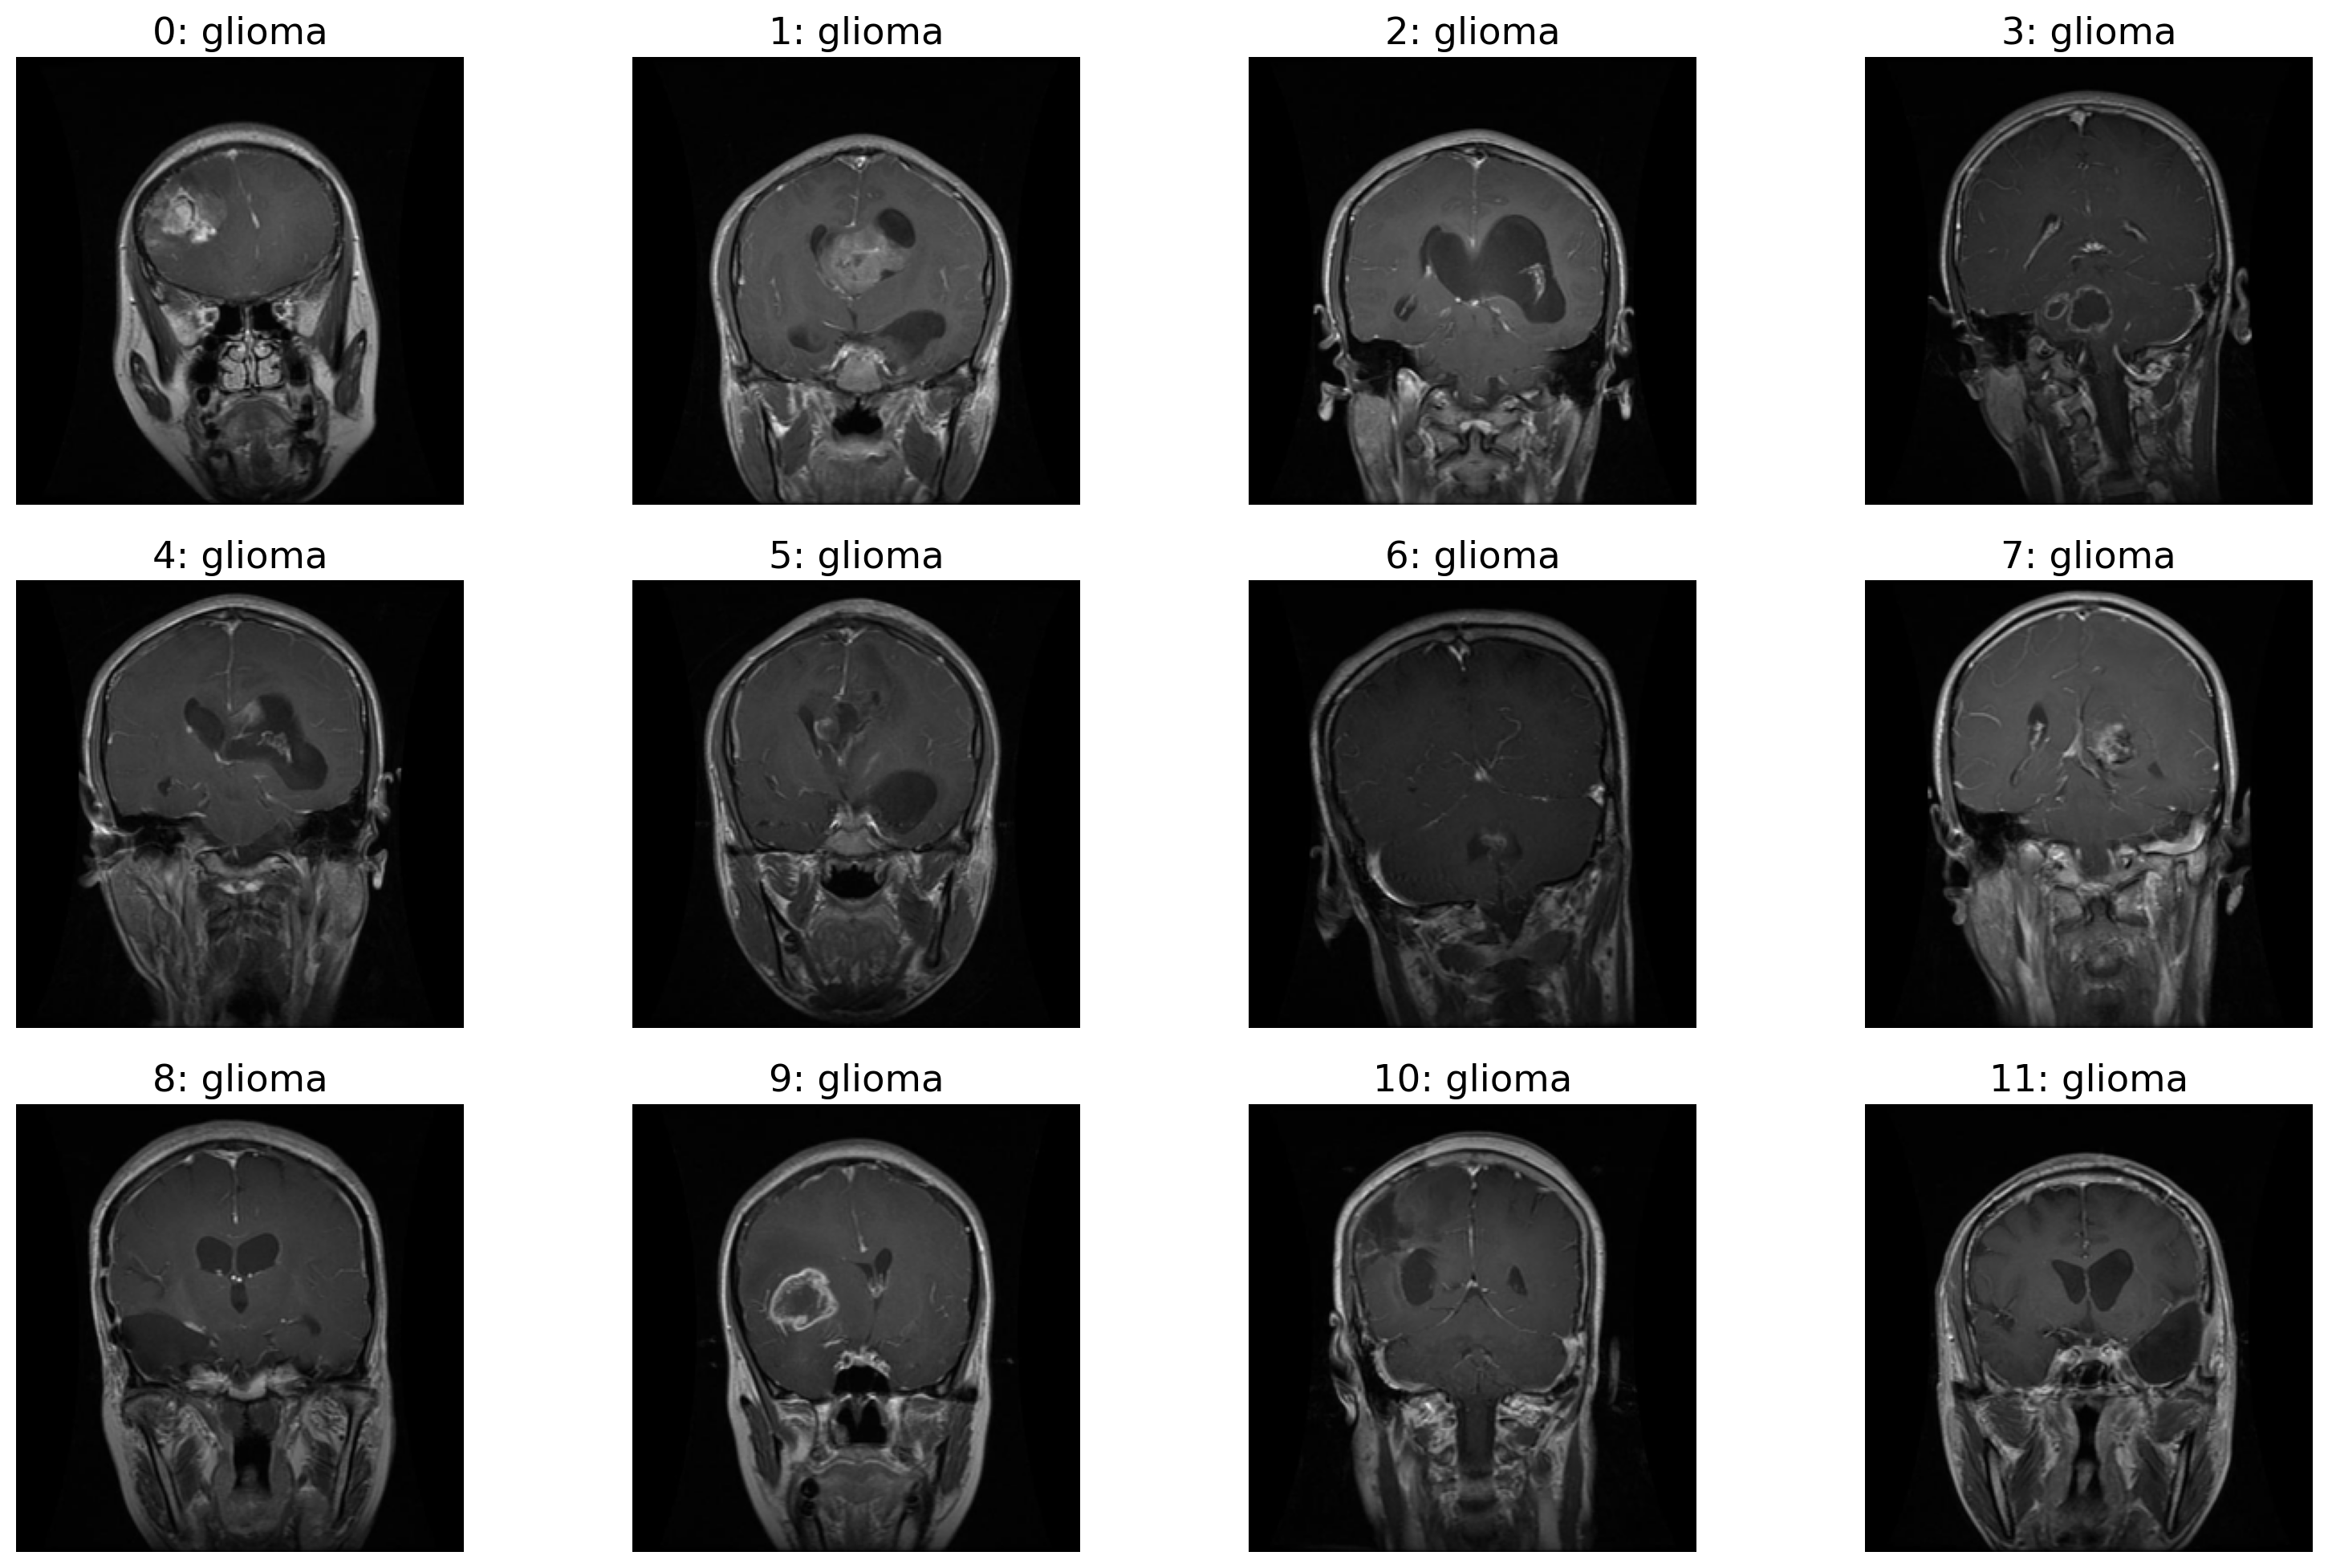

In [4]:
def show_images_pytorch(dataset, class_mappings, index_list=range(10), im_size=250, figsize=(12, 8)):
    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    index_to_class = {v: k for k, v in class_mappings.items()}
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    # Get all image paths from the dataset object
    image_paths = [path for path, _ in dataset.dataset.samples]
    label_indices = [label for _, label in dataset.dataset.samples]

    for i, index in enumerate(index_list):
        if i >= len(ax):
            break
        image = Image.open(image_paths[index]).resize((im_size, im_size))
        ax[i].imshow(image, cmap='Greys_r')
        class_name = index_to_class[label_indices[index]]
        ax[i].set_title(f'{index}: {class_name}')
        ax[i].axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(ax)):
        ax[j].axis('off')

    plt.tight_layout()
    plt.show()

# Display some images from the training set
show_images_pytorch(train_dataset, class_mappings, index_list=range(12), figsize=(16,10))

In [5]:
# Data augmentation is now integrated into the transform pipeline
aug_transforms = transforms.Compose([
    transforms.Resize(image_dim),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=image_dim, scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create a new dataset and loader with augmentations for training
# We re-use the same validation split for consistency
aug_full_train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=aug_transforms)
aug_train_dataset, _ = random_split(aug_full_train_dataset, [train_size, val_size])
aug_train_loader = DataLoader(aug_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

print("Created new DataLoader with augmentations for training.")

Created new DataLoader with augmentations for training.


In [6]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()
        self.features = nn.Sequential(
            # Input Layer is implicit (shape: 1x168x168)
            
            # Convolutional Block 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Convolutional Block 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolutional Block 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 21 * 21, 512), # 168 / 2 / 2 / 2 = 21
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the model and move it to the device
model = BrainTumorCNN(num_classes=len(class_names)).to(device)
print(model)

BrainTumorCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=28224, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=4, bias=True)
  )
)


In [7]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# CORRECTED SCHEDULER: The `verbose=True` argument is removed.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training and Validation Loop
epochs = 50
best_val_loss = float('inf')
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Starting Training...")
for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    # Get the learning rate at the start of the epoch for monitoring
    old_lr = optimizer.param_groups[0]['lr']

    for inputs, labels in aug_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = correct_train / total_train
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    # --- Validation Phase ---
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_val_acc = correct_val / total_val
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    # Learning rate scheduler step
    scheduler.step(epoch_val_loss)

    # --- MODERN WAY TO BE 'VERBOSE' ---
    # Check if the learning rate has changed and print it.
    new_lr = optimizer.param_groups[0]['lr']
    if old_lr != new_lr:
        print(f" -> Learning rate reduced to {new_lr:.6f}")

    # Save the best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model_pytorch.pth')
        print(" -> Saved Best Model")

print("\nFinished Training.")

Starting Training...
Epoch 1/50 | Train Loss: 0.7623, Train Acc: 0.6924 | Val Loss: 0.4847, Val Acc: 0.8199
 -> Saved Best Model
Epoch 2/50 | Train Loss: 0.4613, Train Acc: 0.8243 | Val Loss: 0.4254, Val Acc: 0.8252
 -> Saved Best Model
Epoch 3/50 | Train Loss: 0.3671, Train Acc: 0.8551 | Val Loss: 0.2791, Val Acc: 0.8969
 -> Saved Best Model
Epoch 4/50 | Train Loss: 0.3040, Train Acc: 0.8809 | Val Loss: 0.1801, Val Acc: 0.9371
 -> Saved Best Model
Epoch 5/50 | Train Loss: 0.2675, Train Acc: 0.9019 | Val Loss: 0.1353, Val Acc: 0.9563
 -> Saved Best Model
Epoch 6/50 | Train Loss: 0.2243, Train Acc: 0.9161 | Val Loss: 0.0987, Val Acc: 0.9703
 -> Saved Best Model
Epoch 7/50 | Train Loss: 0.2001, Train Acc: 0.9282 | Val Loss: 0.0997, Val Acc: 0.9720
Epoch 8/50 | Train Loss: 0.1624, Train Acc: 0.9424 | Val Loss: 0.0896, Val Acc: 0.9773
 -> Saved Best Model
Epoch 9/50 | Train Loss: 0.1446, Train Acc: 0.9475 | Val Loss: 0.0693, Val Acc: 0.9755
 -> Saved Best Model
Epoch 10/50 | Train Loss: 0.

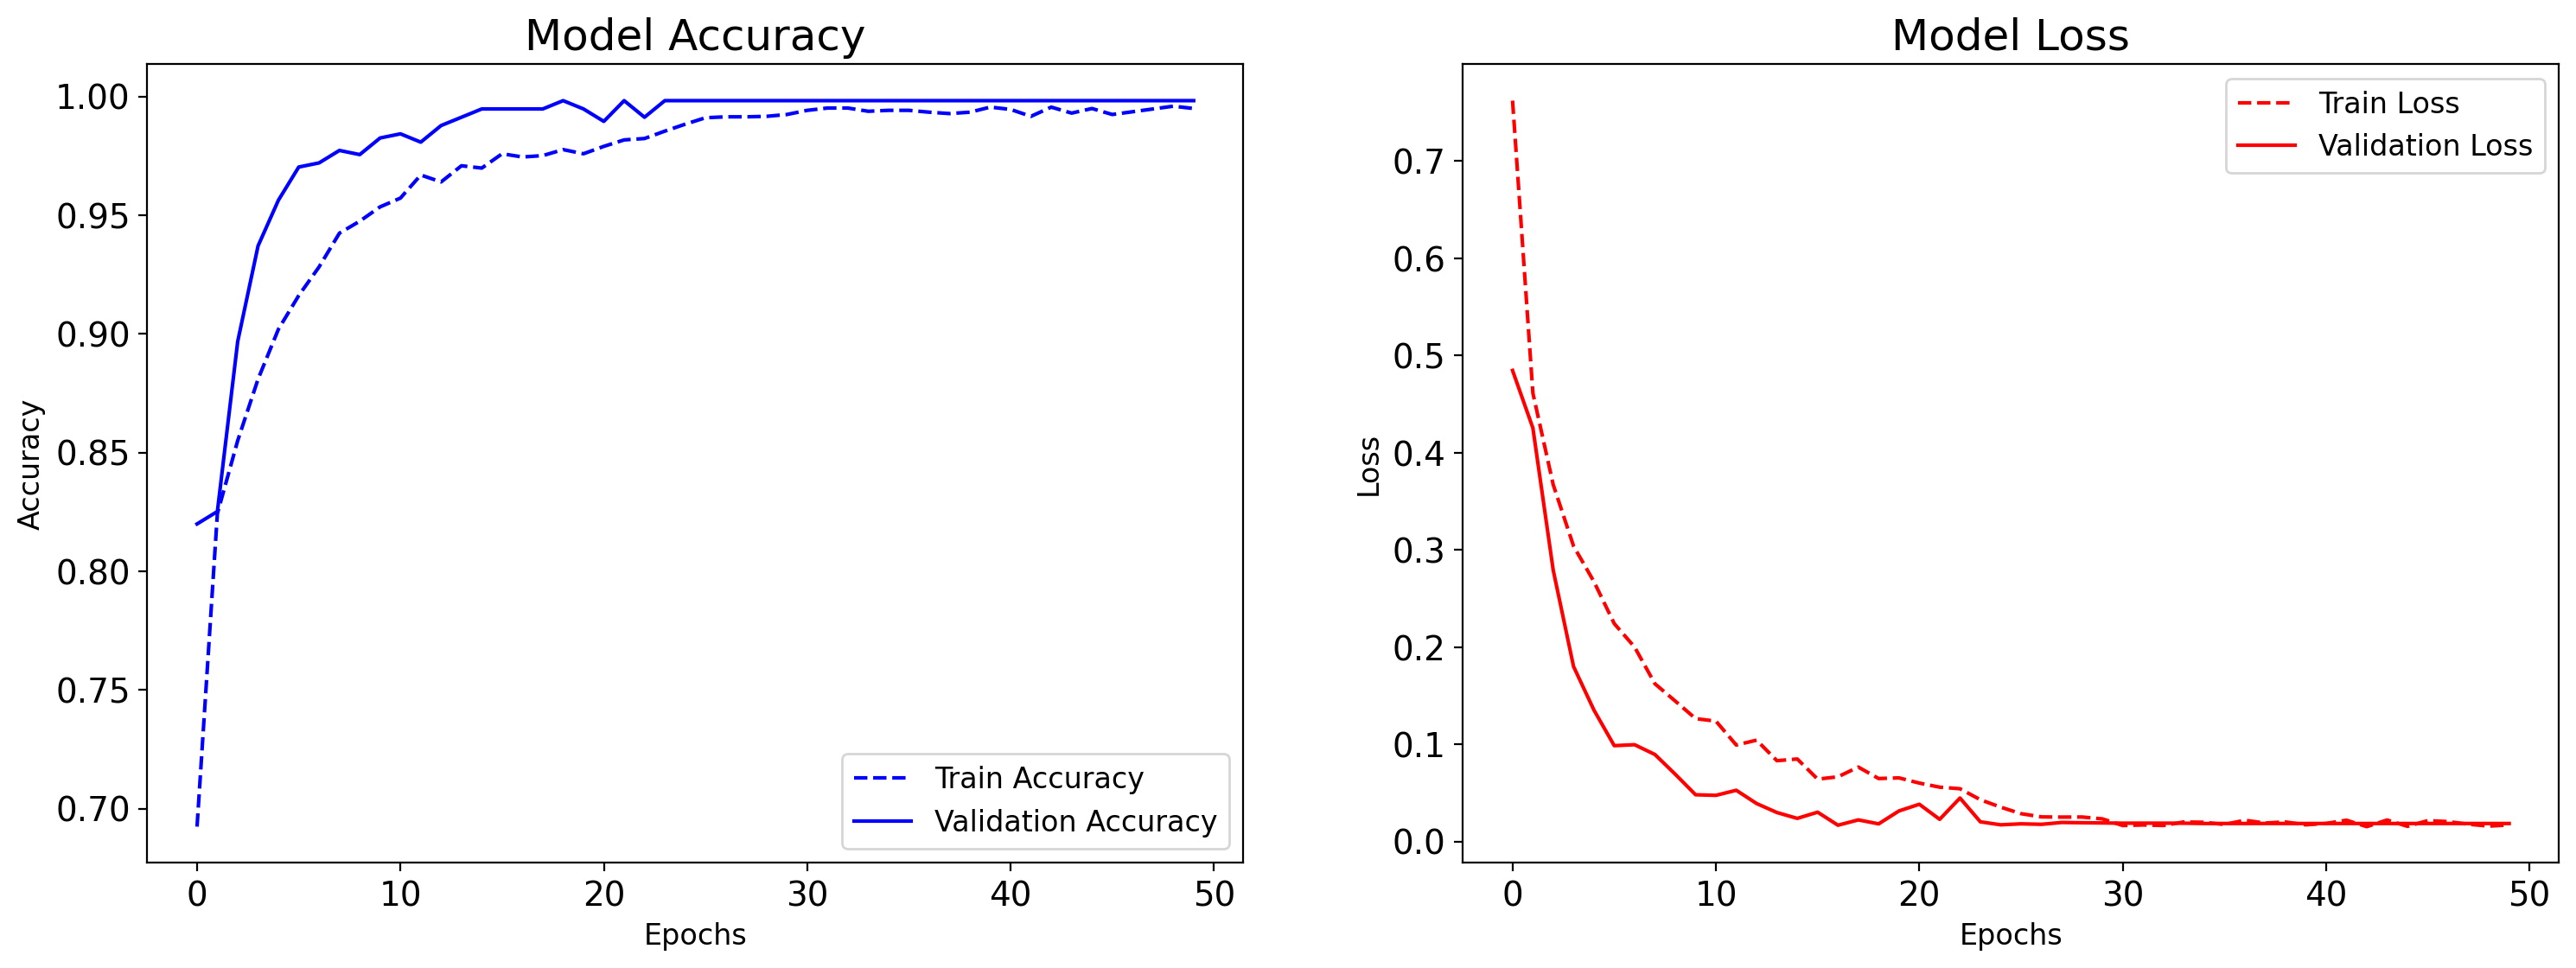

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plotting accuracy
ax[0].plot(history['train_acc'], label='Train Accuracy', color='blue', linestyle='--')
ax[0].plot(history['val_acc'], label='Validation Accuracy', color='blue')
ax[0].set_title('Model Accuracy', fontsize=18)
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].legend(fontsize=12)

# Plotting loss
ax[1].plot(history['train_loss'], label='Train Loss', color='red', linestyle='--')
ax[1].plot(history['val_loss'], label='Validation Loss', color='red')
ax[1].set_title('Model Loss', fontsize=18)
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].legend(fontsize=12)

plt.show()

Final Test Loss: 0.1355
Final Test Accuracy: 0.9626

--- Classification Report ---
              precision    recall  f1-score   support

      glioma       0.98      0.95      0.96       300
  meningioma       0.95      0.90      0.92       306
     notumor       0.94      1.00      0.97       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.96      1311
   macro avg       0.97      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311


--- Per-Class Metrics from Confusion Matrix ---
     Class Accuracy Precision Recall F1-Score  TP  FP  FN   TN
    glioma   0.9840    0.9827 0.9467   0.9643 284   5  16 1006
meningioma   0.9657    0.9485 0.9020   0.9246 276  15  30  990
   notumor   0.9786    0.9394 0.9951   0.9664 403  26   2  880
 pituitary   0.9969    0.9901 0.9967   0.9934 299   3   1 1008


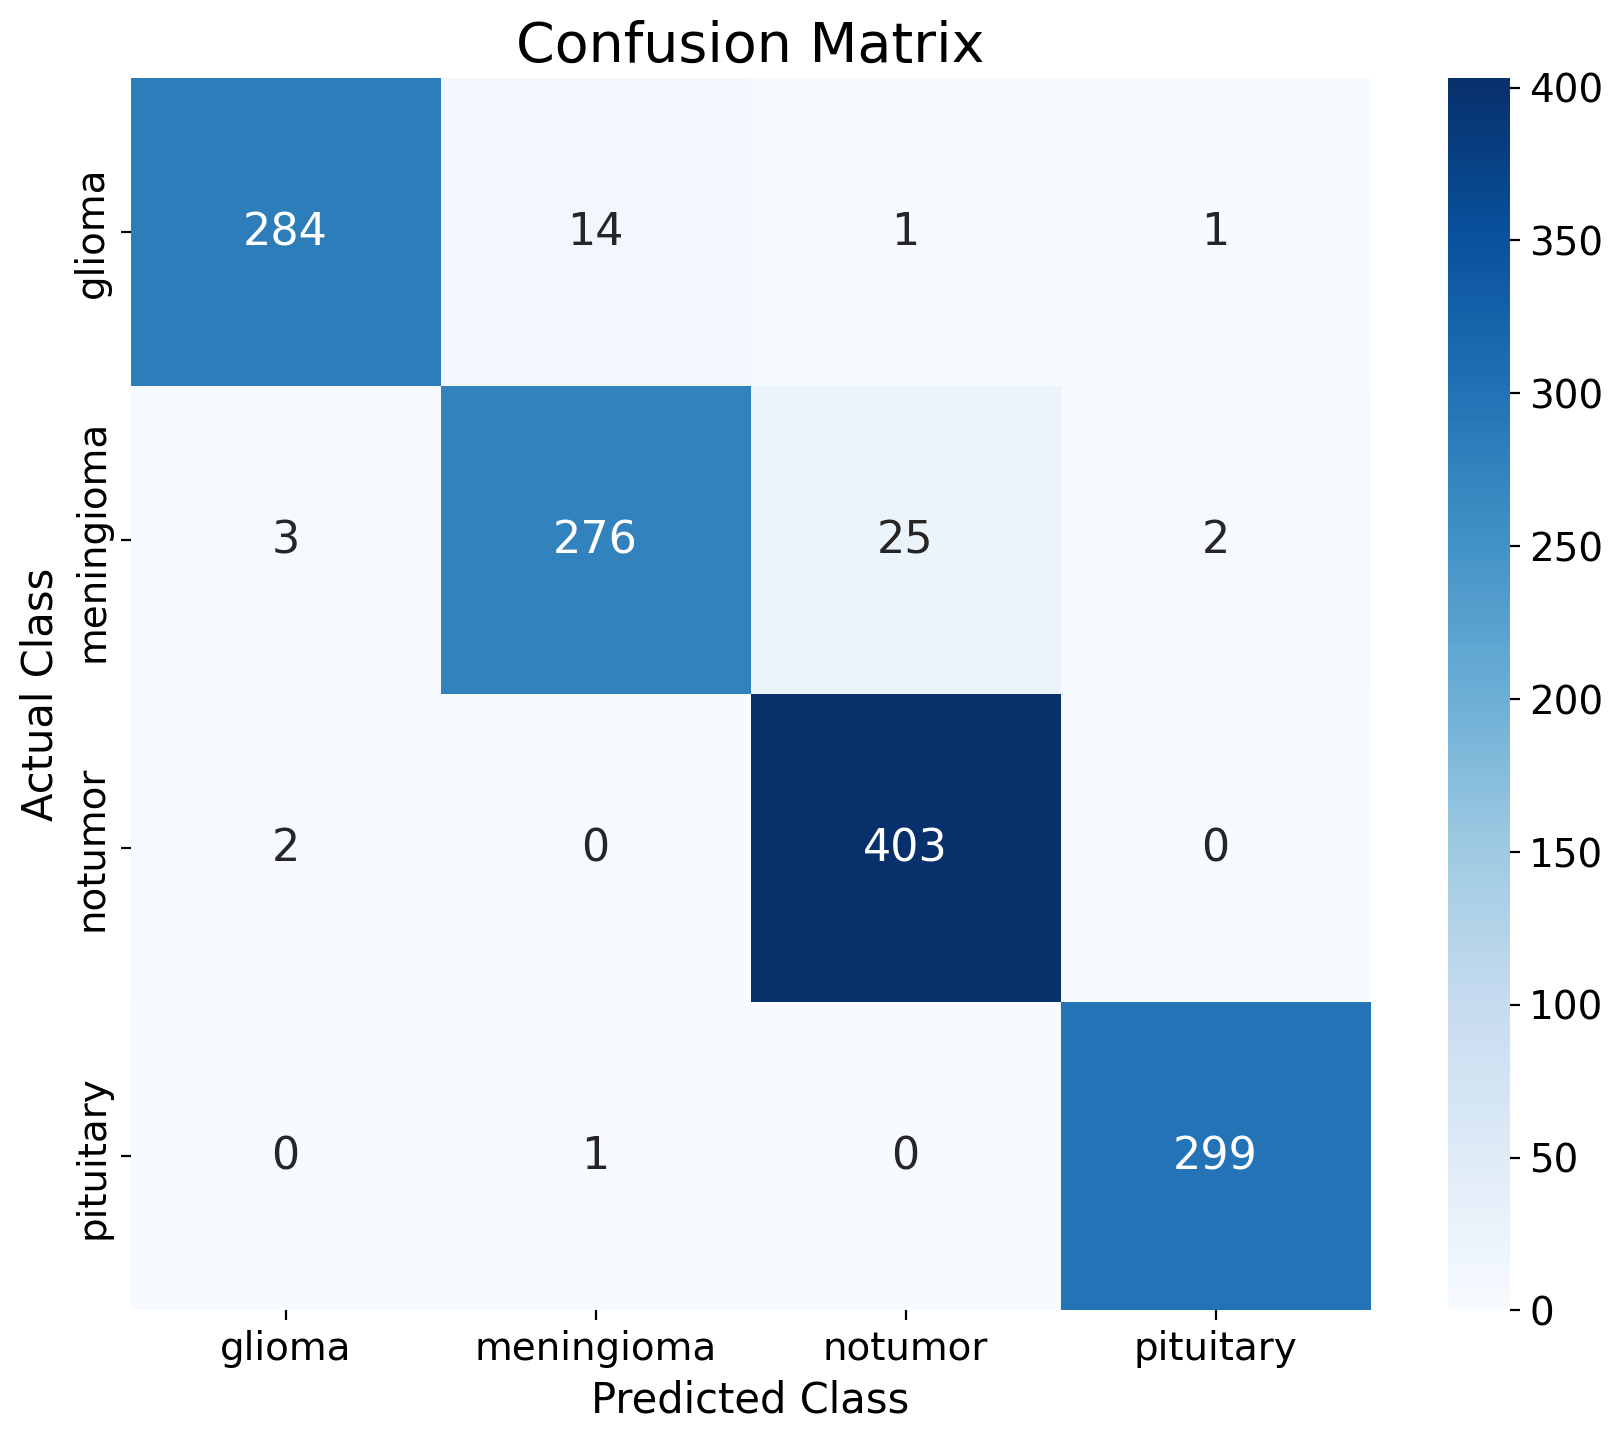

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- This is your existing evaluation code ---

# Load the best model weights
model.load_state_dict(torch.load('best_model_pytorch.pth'))

model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_test_loss = test_loss / len(test_dataset)
final_test_acc = correct_test / total_test

print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_acc:.4f}\n")


# --- New code for detailed, per-class reporting ---

print("--- Classification Report ---")
# Use the class names from the dataset for clear labeling
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)


print("\n--- Per-Class Metrics from Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)

# Calculate per-class metrics manually for detailed breakdown
metrics_data = []
for i, class_name in enumerate(class_names):
    # True Positives (TP): Diagonal elements
    tp = cm[i, i]
    # False Positives (FP): Sum of the column, excluding the diagonal
    fp = cm[:, i].sum() - tp
    # False Negatives (FN): Sum of the row, excluding the diagonal
    fn = cm[i, :].sum() - tp
    # True Negatives (TN): Sum of all cells minus TP, FP, and FN for that class
    tn = cm.sum() - (tp + fp + fn)

    # Accuracy for this class
    class_accuracy = (tp + tn) / cm.sum()
    # Precision (how many selected items are relevant?)
    class_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # Recall (how many relevant items are selected?)
    class_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # F1-Score (harmonic mean of precision and recall)
    class_f1 = 2 * (class_precision * class_recall) / (class_precision + class_recall) if (class_precision + class_recall) > 0 else 0

    metrics_data.append({
        "Class": class_name,
        "Accuracy": f"{class_accuracy:.4f}",
        "Precision": f"{class_precision:.4f}",
        "Recall": f"{class_recall:.4f}",
        "F1-Score": f"{class_f1:.4f}",
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn
    })

# Display the results in a clean DataFrame
df_metrics = pd.DataFrame(metrics_data)
print(df_metrics.to_string(index=False))


# Optional: Re-display the confusion matrix for context
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 16})
plt.title('Confusion Matrix', fontsize=20)
plt.ylabel('Actual Class', fontsize=15)
plt.xlabel('Predicted Class', fontsize=15)
plt.show()

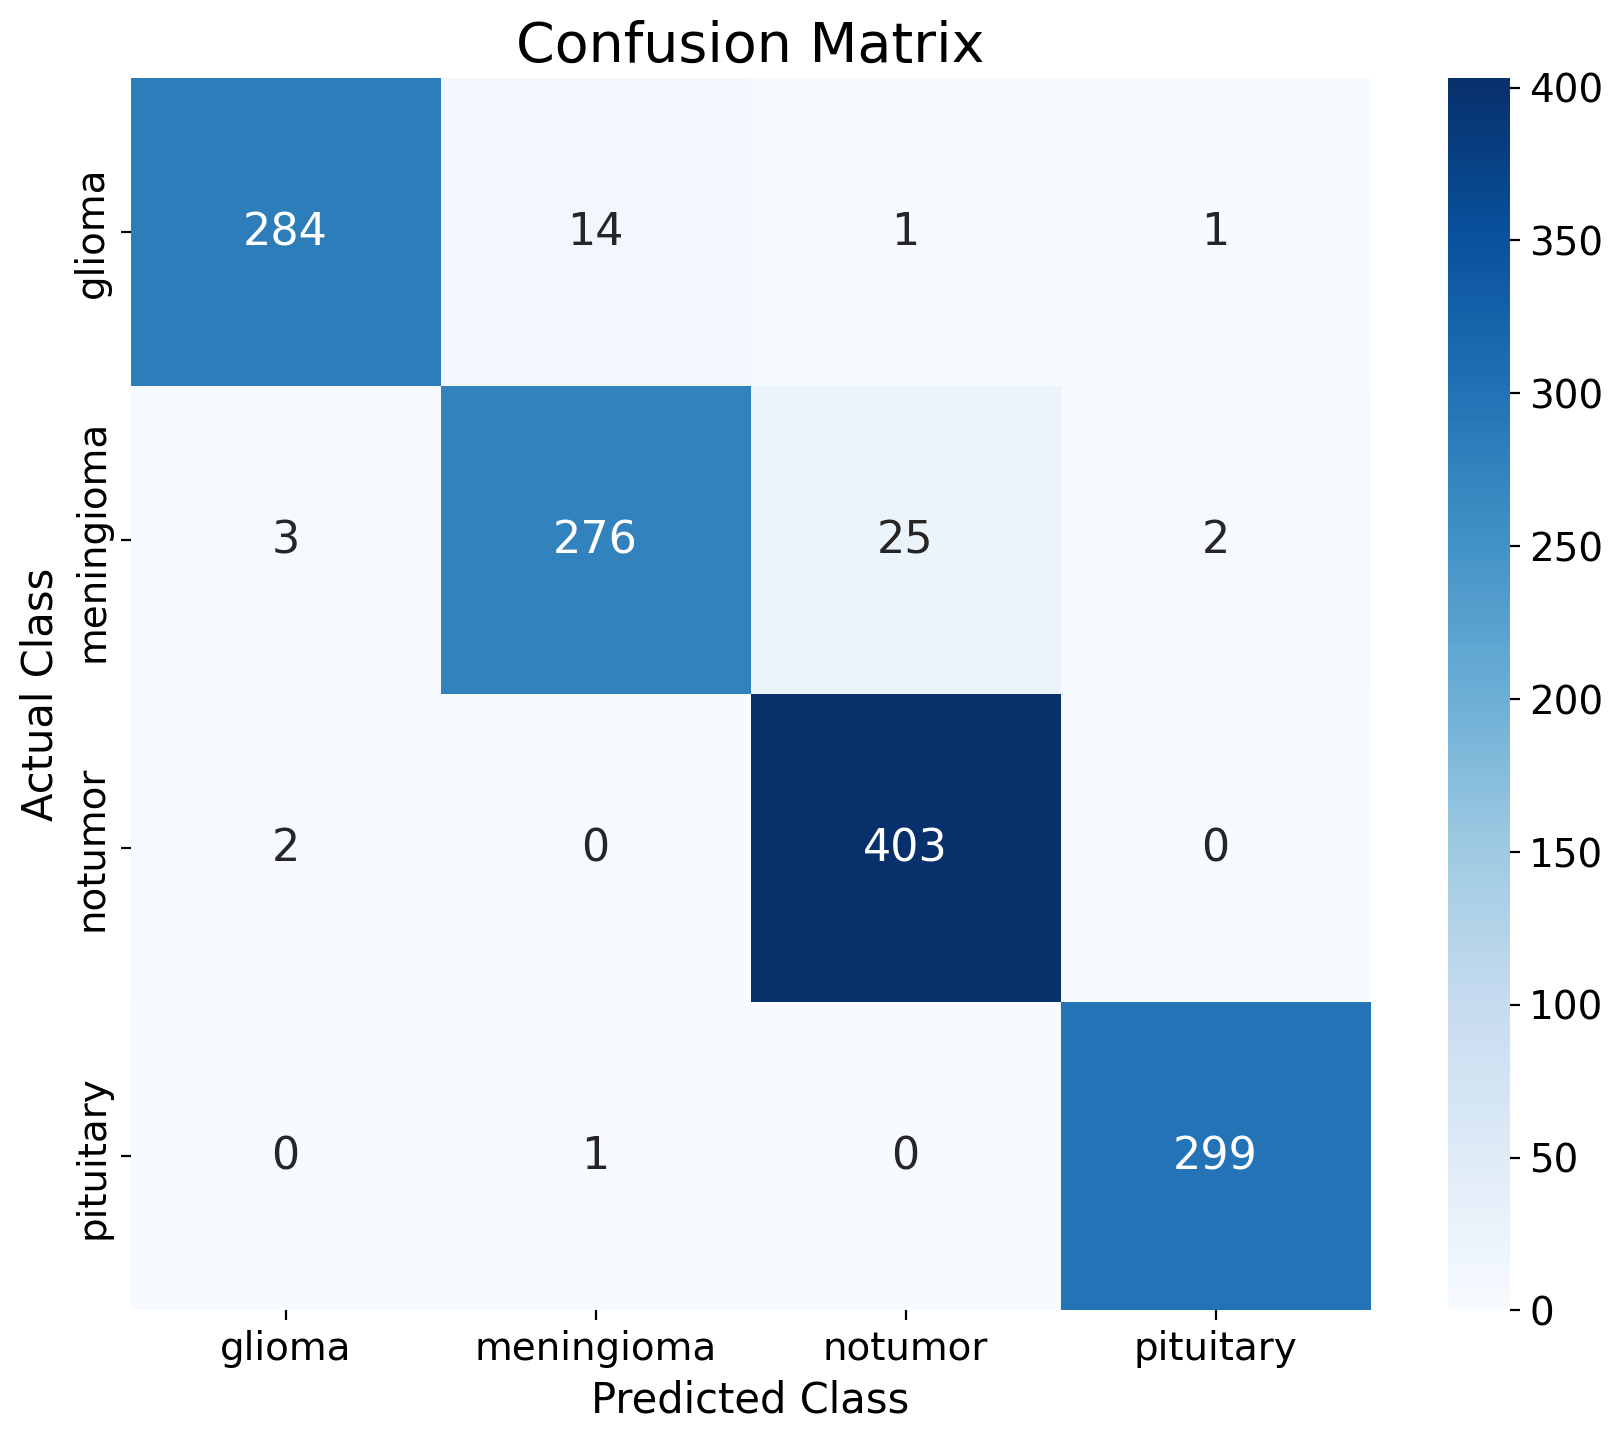

In [10]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 16})
plt.title('Confusion Matrix', fontsize=20)
plt.ylabel('Actual Class', fontsize=15)
plt.xlabel('Predicted Class', fontsize=15)
plt.show()